<a href="https://colab.research.google.com/github/JihongOh/PC-netpharm-transcriptomics/blob/main/DEG_analysis/Volcano_Plot_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Volcano Plot Analysis for Differential Gene Expression

This notebook generates volcano plots for visualizing differential gene expression data.

**Datasets:**
- GSE20950: Adipose tissue (insulin-resistant vs insulin-sensitive)
- GSE43292: Atheroma plaque vs intact arterial tissue

**Author:** Jihong Oh
**Date:** 2026-01-26

## 1. Install Required Packages

For Google Colab, install `adjustText` package:

In [1]:
# Install adjustText for automatic label positioning
!pip install adjustText -q
print("✓ Package installed successfully!")

✓ Package installed successfully!


## 2. Import Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from adjustText import adjust_text

# For Google Colab file upload
try:
    from google.colab import files
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

print("✓ Libraries imported successfully!")

✓ Libraries imported successfully!


## 3. Configuration

In [3]:
# Statistical thresholds
PVAL_THRESHOLD = 0.01      # P-value threshold (NOT adjusted p-value)
LOG2FC_THRESHOLD = 0.58    # Log2 fold change threshold (absolute value)

# Genes of interest (related to ≥2 compounds, cardiometabolic/inflammatory pathways)
GENES_OF_INTEREST = [
    'AKT1', 'BAX', 'BCL2', 'CASP1', 'CCL2', 'CTNNB1', 'GSK3B', 'HMOX1',
    'ICAM1', 'IFNB1', 'IFNG', 'IL10', 'IL1B', 'IL6', 'INS', 'KDR',
    'MAPK1', 'MAPK14', 'MAPK3', 'MAPK8', 'MAPT', 'MMP3', 'MTOR',
    'MUC5AC', 'MYC', 'NFKB1', 'NLRP3', 'NOS2', 'NOX4', 'PPARA',
    'PPARG', 'PPARGC1A', 'PTGS2', 'SIRT1', 'SLC2A1', 'SMAD3',
    'STAT3', 'TGFB1', 'TLR4', 'TNF', 'TP53', 'VCAM1', 'VEGFA'
]

print(f"Thresholds: P-value < {PVAL_THRESHOLD}, |log2FC| > {LOG2FC_THRESHOLD}")
print(f"Genes to label: {len(GENES_OF_INTEREST)}")

Thresholds: P-value < 0.01, |log2FC| > 0.58
Genes to label: 43


## 4. File Upload

Upload your TSV files containing differential expression data.

In [4]:
if IN_COLAB:
    print("📁 Please upload your TSV files:")
    print("  1. GSE20950_top_table.tsv")
    print("  2. GSE43292_top_table.tsv")
    uploaded = files.upload()

    # Find files by name
    uploaded_files = list(uploaded.keys())
    gse20950_file = [f for f in uploaded_files if 'GSE20950' in f or '20950' in f][0]
    gse43292_file = [f for f in uploaded_files if 'GSE43292' in f or '43292' in f][0]

    print(f"\n✓ Files uploaded:")
    print(f"  GSE20950: {gse20950_file}")
    print(f"  GSE43292: {gse43292_file}")
else:
    # For local execution, specify file paths
    gse20950_file = 'GSE20950_top_table.tsv'
    gse43292_file = 'GSE43292_top_table.tsv'
    print(f"Using local files: {gse20950_file}, {gse43292_file}")

📁 Please upload your TSV files:
  1. GSE20950_top_table.tsv
  2. GSE43292_top_table.tsv


Saving GSE20950.top.table_26.01.23.tsv to GSE20950.top.table_26.01.23.tsv
Saving GSE43292.top.table_26.01.23.tsv to GSE43292.top.table_26.01.23.tsv

✓ Files uploaded:
  GSE20950: GSE20950.top.table_26.01.23.tsv
  GSE43292: GSE43292.top.table_26.01.23.tsv


## 5. Data Loading and Preprocessing

In [5]:
def load_and_clean_data(filename):
    """
    Load and clean DEG data from TSV file.

    Processing steps:
    1. Remove rows with NaN or empty gene symbols
    2. Remove ambiguous probes (containing '///')
    3. Calculate -log10(P.Value) for visualization
    4. Remove duplicates (keep gene with lowest adj.P.Val)
    """
    print(f"\n📊 Loading {filename}...")

    # Load data
    df = pd.read_csv(filename, sep='\t')
    print(f"  Initial rows: {len(df)}")

    # Remove NaN and empty gene symbols
    df = df[df['Gene.symbol'].notna()]
    df = df[df['Gene.symbol'] != '']
    print(f"  After removing NaN/empty: {len(df)}")

    # Remove ambiguous probes
    df = df[~df['Gene.symbol'].str.contains('///', na=False)]
    print(f"  After removing ambiguous probes: {len(df)}")

    # Calculate -log10(P.Value) - using P.Value, not adj.P.Val
    df['neglog10_P'] = -np.log10(df['P.Value'])

    # Remove duplicates - keep the one with SMALLEST adj.P.Val
    print(f"  Before removing duplicates: {len(df)}")
    df = df.sort_values('adj.P.Val').groupby('Gene.symbol').first().reset_index()
    print(f"  After removing duplicates: {len(df)} unique genes")
    print(f"  Max -log10(P.Value): {df['neglog10_P'].max():.2f}\n")

    return df

# Load both datasets
uploaded_files = list(uploaded.keys())

# Find the correct files by name
gse20950_file = [f for f in uploaded_files if 'GSE20950' in f or '20950' in f][0]
gse43292_file = [f for f in uploaded_files if 'GSE43292' in f or '43292' in f][0]

gse20950_data = load_and_clean_data(gse20950_file)
gse43292_data = load_and_clean_data(gse43292_file)


📊 Loading GSE20950.top.table_26.01.23.tsv...
  Initial rows: 54675
  After removing NaN/empty: 45118
  After removing ambiguous probes: 42904
  Before removing duplicates: 42904
  After removing duplicates: 20848 unique genes
  Max -log10(P.Value): 23.09


📊 Loading GSE43292.top.table_26.01.23.tsv...
  Initial rows: 33297
  After removing NaN/empty: 22195
  After removing ambiguous probes: 20052
  Before removing duplicates: 20052
  After removing duplicates: 19036 unique genes
  Max -log10(P.Value): 8.93



## 6. Volcano Plot Function

In [6]:
def create_volcano_plot(df, dataset_name, pval_thresh=0.01, fc_thresh=0.58,
                       genes_to_label=None, figsize=(8, 7)):
    """
    Create a volcano plot for DEG visualization.

    Uses P.Value (not adj.P.Val) for thresholding and visualization.
    """
    print(f"\n{'='*80}")
    print(f"Creating Volcano Plot: {dataset_name}")
    print(f"{'='*80}")

    # Classify genes based on thresholds (using P.Value)
    df['color'] = 'gray'
    df.loc[(df['logFC'] < -fc_thresh) & (df['P.Value'] < pval_thresh), 'color'] = 'blue'
    df.loc[(df['logFC'] > fc_thresh) & (df['P.Value'] < pval_thresh), 'color'] = 'red'

    # Count DEGs
    n_down = (df['color'] == 'blue').sum()
    n_up = (df['color'] == 'red').sum()
    print(f"  Downregulated DEGs (blue): {n_down}")
    print(f"  Upregulated DEGs (red): {n_up}")
    print(f"  Total significant DEGs: {n_down + n_up}")

    # Create figure
    fig, ax = plt.subplots(figsize=figsize)

    # Plot points
    for color in ['gray', 'blue', 'red']:
        subset = df[df['color'] == color]
        ax.scatter(subset['logFC'], subset['neglog10_P'],
                  c=color, s=20, alpha=0.6, edgecolors='none',
                  zorder=1 if color == 'gray' else 2)

    # Threshold lines
    ax.axhline(-np.log10(pval_thresh), color='gray', linestyle='--', linewidth=1.5, alpha=0.7, zorder=0)
    ax.axvline(-fc_thresh, color='gray', linestyle='--', linewidth=1.5, alpha=0.7, zorder=0)
    ax.axvline(fc_thresh, color='gray', linestyle='--', linewidth=1.5, alpha=0.7, zorder=0)

    # Label genes of interest
    texts = []
    if genes_to_label:
        genes_in_data = df[df['Gene.symbol'].isin(genes_to_label)]
        genes_significant = genes_in_data[genes_in_data['color'].isin(['blue', 'red'])]

        print(f"\n  Significant genes to label: {len(genes_significant)}")

        if len(genes_significant) > 0:
            print(f"  Labeling genes:")
            for _, gene_row in genes_significant.iterrows():
                gene = gene_row['Gene.symbol']
                x = gene_row['logFC']
                y = gene_row['neglog10_P']

                txt = ax.text(x, y, gene, fontsize=11, fontweight='bold',
                             ha='center', va='center', color='black', zorder=3)
                texts.append(txt)
                print(f"    {gene}: logFC={x:.2f}, -log10(P)={y:.2f}")

        # Adjust text positions to avoid overlap
        if texts:
            adjust_text(texts,
                       arrowprops=dict(arrowstyle='-', color='black', lw=0.7, alpha=0.8),
                       ax=ax)

    # Formatting
    ax.set_xlabel('log2 Fold Change', fontsize=14, fontweight='bold')
    ax.set_ylabel('-log10(P-value)', fontsize=14, fontweight='bold')

    # Set axis limits
    x_max = max(abs(df['logFC'].min()), abs(df['logFC'].max()))
    ax.set_xlim(-x_max * 1.1, x_max * 1.1)
    y_max = df['neglog10_P'].max()
    ax.set_ylim(-0.5, y_max * 1.05)

    # Thicker spines
    ax.spines['top'].set_linewidth(1.5)
    ax.spines['right'].set_linewidth(1.5)
    ax.spines['left'].set_linewidth(1.5)
    ax.spines['bottom'].set_linewidth(1.5)

    # Larger tick labels
    ax.tick_params(axis='both', which='major', labelsize=11)

    plt.tight_layout()

    # Save figure
    filename = f"{dataset_name.replace(' ', '_')}_volcano_plot.png"
    plt.savefig(filename, dpi=300, bbox_inches='tight', facecolor='white')
    print(f"\n✓ Figure saved: {filename}")

    plt.show()

    return filename

## 7. Generate Volcano Plots


Creating Volcano Plot: GSE20950
  Downregulated DEGs (blue): 1869
  Upregulated DEGs (red): 184
  Total significant DEGs: 2053

  Significant genes to label: 9
  Labeling genes:
    BCL2: logFC=-0.58, -log10(P)=4.69
    IFNG: logFC=0.59, -log10(P)=5.57
    MAPK1: logFC=-0.74, -log10(P)=5.32
    MAPK14: logFC=-0.88, -log10(P)=5.16
    MAPT: logFC=-0.65, -log10(P)=2.79
    NOX4: logFC=-0.59, -log10(P)=3.88
    PPARA: logFC=-0.94, -log10(P)=10.48
    TGFB1: logFC=-0.78, -log10(P)=6.87
    VEGFA: logFC=-0.62, -log10(P)=4.60

✓ Figure saved: GSE20950_volcano_plot.png


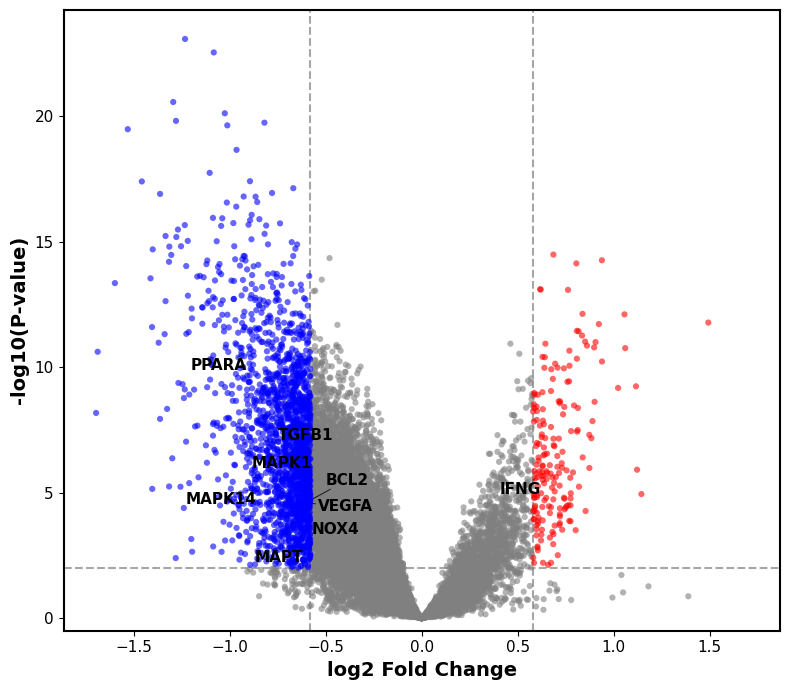

In [7]:
# GSE20950 plot
file1 = create_volcano_plot(
    gse20950_data,
    'GSE20950',
    pval_thresh=PVAL_THRESHOLD,
    fc_thresh=LOG2FC_THRESHOLD,
    genes_to_label=GENES_OF_INTEREST,
    figsize=(8, 7)
)


Creating Volcano Plot: GSE43292
  Downregulated DEGs (blue): 374
  Upregulated DEGs (red): 521
  Total significant DEGs: 895

  Significant genes to label: 7
  Labeling genes:
    CASP1: logFC=0.64, -log10(P)=5.39
    HMOX1: logFC=1.42, -log10(P)=6.36
    ICAM1: logFC=0.75, -log10(P)=5.18
    IL1B: logFC=0.78, -log10(P)=3.18
    NLRP3: logFC=0.71, -log10(P)=6.63
    NOX4: logFC=-0.88, -log10(P)=6.99
    PPARG: logFC=0.69, -log10(P)=4.27

✓ Figure saved: GSE43292_volcano_plot.png


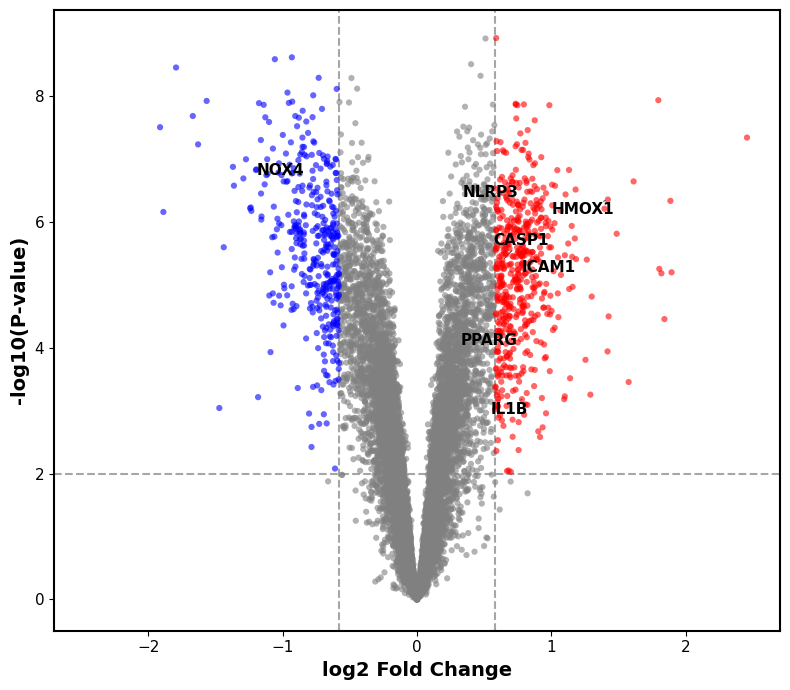

In [8]:
# GSE43292 plot
file2 = create_volcano_plot(
    gse43292_data,
    'GSE43292',
    pval_thresh=PVAL_THRESHOLD,
    fc_thresh=LOG2FC_THRESHOLD,
    genes_to_label=GENES_OF_INTEREST,
    figsize=(8, 7)
)

## 8. Download Files (Google Colab)

In [ ]:
if IN_COLAB:
    print("\n📥 Downloading files...")
    files.download(file1)
    files.download(file2)
    print("✓ Download complete!")
else:
    print(f"\n✓ Files saved locally:")
    print(f"  - {file1}")
    print(f"  - {file2}")